In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

# Data loading and preprocessing

In [2]:
from keras.datasets import cifar100
(X_train, y_train), (X_test, y_test) = cifar100.load_data()
X_valid, y_valid, X_train, y_train = X_train[:10000]/255.0, y_train[:10000], X_train[10000:]/255.0, y_train[10000:]
X_test = X_test/255.0
X_train.min(), X_train.max(), X_valid.min(), X_valid.max(), X_test.min(), X_test.max()

169001437/169001437 [==============================] - 4s 0us/step


(0.0, 1.0, 0.0, 1.0, 0.0, 1.0)

In [3]:
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((40000, 32, 32, 3),
 (10000, 32, 32, 3),
 (10000, 32, 32, 3),
 (40000, 1),
 (10000, 1),
 (10000, 1))

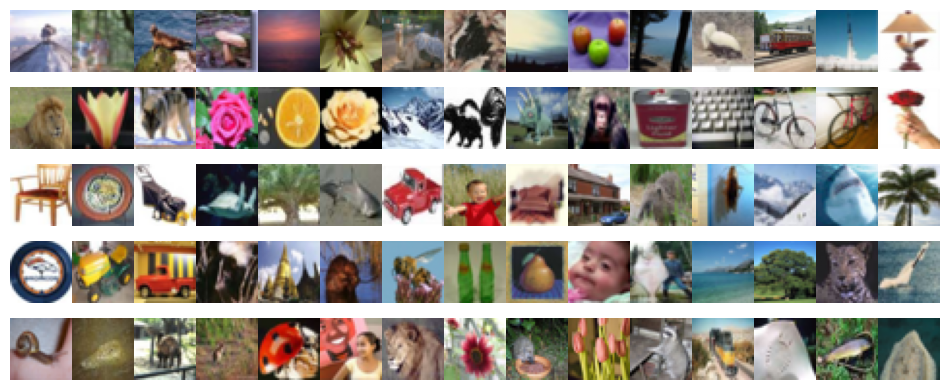

In [4]:
num_rows, num_cols = 5, 15
fig, axs = plt.subplots(num_rows, num_cols)
fig.set_figwidth(12)
fig.set_figheight(5)
count = 0
for row in range(num_rows):
    for col in range(num_cols):
        axs[row, col].imshow(X_test[count])
        axs[row, col].axis("off")
        count += 1
plt.subplots_adjust(wspace = 0.0, hspace = 0.0)
plt.show()

# Blurring the images

In [5]:
from scipy.ndimage import gaussian_filter
blurred_X_train = gaussian_filter(X_train, sigma = 0.7)
blurred_X_valid = gaussian_filter(X_valid, sigma = 0.7)
blurred_X_test = gaussian_filter(X_test, sigma = 0.7)

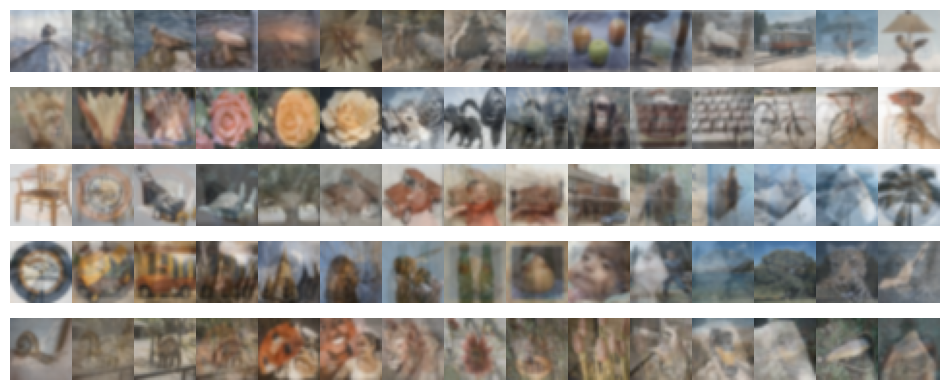

In [6]:
num_rows, num_cols = 5, 15
fig, axs = plt.subplots(num_rows, num_cols)
fig.set_figwidth(12)
fig.set_figheight(5)
count = 0
for row in range(num_rows):
    for col in range(num_cols):
        axs[row, col].imshow(blurred_X_test[count])
        axs[row, col].axis("off")
        count += 1
plt.subplots_adjust(wspace = 0.0, hspace = 0.0)
plt.show()

# Defining and training the model

In [7]:
encoder = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size = 3, strides = 1, padding = "same",
                       activation = "relu", kernel_initializer = "he_normal",
                       input_shape = [32, 32, 3]),
    keras.layers.Conv2D(128, kernel_size = 3, strides = 1, padding = "same",
                       activation = "relu", kernel_initializer = "he_normal",),
    keras.layers.Conv2D(256, kernel_size = 3, strides = 1, padding = "same",
                       activation = "relu", kernel_initializer = "he_normal",),
    keras.layers.Conv2D(512, kernel_size = 3, strides = 1, padding = "same",
                       activation = "relu", kernel_initializer = "he_normal",)
])
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 256)       295168    
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 512)       1180160   
                                                                 
Total params: 1550976 (5.92 MB)
Trainable params: 1550976 (5.92 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(256, kernel_size = 3, strides = 1, padding = "same",
                                activation = "relu", kernel_initializer = "he_normal",
                                input_shape = [32, 32, 512]),
    keras.layers.Conv2DTranspose(128, kernel_size = 3, strides = 1, padding = "same",
                                activation = "relu", kernel_initializer = "he_normal",),
    keras.layers.Conv2DTranspose(64, kernel_size = 3, strides = 1, padding = "same",
                                activation = "relu", kernel_initializer = "he_normal",),
    keras.layers.Conv2DTranspose(3, kernel_size = 3, strides = 1, padding = "same",
                                activation = "sigmoid", kernel_initializer = "glorot_normal")
])
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTr  (None, 32, 32, 256)       1179904   
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 32, 32, 128)       295040    
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 32, 32, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 32, 32, 3)         1731      
 Transpose)                                                      
                                                                 
Total params: 1550467 (5.91 MB)
Trainable params: 1550

In [9]:
denoising_ae = keras.models.Sequential([encoder, decoder])
denoising_ae.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 32, 32, 512)       1550976   
                                                                 
 sequential_1 (Sequential)   (None, 32, 32, 3)         1550467   
                                                                 
Total params: 3101443 (11.83 MB)
Trainable params: 3101443 (11.83 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
denoising_ae.compile(loss = "binary_crossentropy",
                     optimizer = keras.optimizers.SGD(learning_rate = 0.01,
                                                  momentum = 0.9,
                                                  nesterov = True),
                    #seems like Adam is not good for this task
                    metrics = ["accuracy"])

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("so_far_best.h5", save_best_only = True, verbose = 1)
history = denoising_ae.fit(
    blurred_X_train, X_train,
    epochs = 1000,
    batch_size = 256,
    validation_data = (blurred_X_valid, X_valid),
    callbacks = [checkpoint,
                 keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)]
)

Epoch 1/1000
157/157 [==============================] - ETA: 0s - loss: 0.6432 - accuracy: 0.5522
Epoch 1: val_loss improved from inf to 0.59191, saving model to so_far_best.h5
157/157 [==============================] - 115s 585ms/step - loss: 0.6432 - accuracy: 0.5522 - val_loss: 0.5919 - val_accuracy: 0.6033
Epoch 2/1000


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


157/157 [==============================] - ETA: 0s - loss: 0.5787 - accuracy: 0.6210
Epoch 2: val_loss improved from 0.59191 to 0.57560, saving model to so_far_best.h5
157/157 [==============================] - 90s 572ms/step - loss: 0.5787 - accuracy: 0.6210 - val_loss: 0.5756 - val_accuracy: 0.6343
Epoch 3/1000
157/157 [==============================] - ETA: 0s - loss: 0.5739 - accuracy: 0.6489
Epoch 3: val_loss improved from 0.57560 to 0.57113, saving model to so_far_best.h5
157/157 [==============================] - 86s 550ms/step - loss: 0.5739 - accuracy: 0.6489 - val_loss: 0.5711 - val_accuracy: 0.6729
Epoch 4/1000
157/157 [==============================] - ETA: 0s - loss: 0.5708 - accuracy: 0.6693
Epoch 4: val_loss improved from 0.57113 to 0.56921, saving model to so_far_best.h5
157/157 [==============================] - 90s 572ms/step - loss: 0.5708 - accuracy: 0.6693 - val_loss: 0.5692 - val_accuracy: 0.6708
Epoch 5/1000
157/157 [==============================] - ETA: 0s - lo

KeyboardInterrupt: ignored

In [12]:
denoising_ae.evaluate(X_test, X_test)

313/313 [==============================] - 8s 21ms/step - loss: 0.6301 - accuracy: 0.7901


[0.6301371455192566, 0.7901469469070435]

In [15]:
import pandas as pd
#pd.DataFrame(history.history).plot(figsize = (15, 10))
#plt.grid(True)
#plt.show()

In [16]:
latent_repr = encoder.predict(blurred_X_test[:75])
reconstructions = decoder.predict(latent_repr)

3/3 [==============================] - 1s 192ms/step


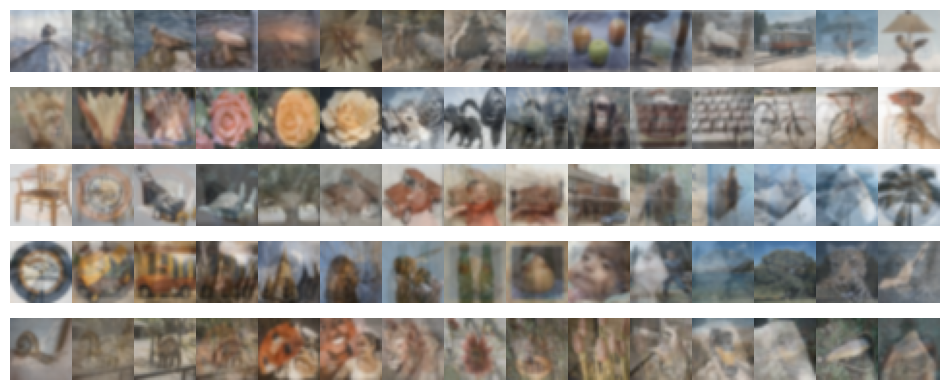

In [17]:
num_rows, num_cols = 5, 15
fig, axs = plt.subplots(num_rows, num_cols)
fig.set_figwidth(12)
fig.set_figheight(5)
count = 0
for row in range(num_rows):
    for col in range(num_cols):
        axs[row, col].imshow(blurred_X_test[count])
        axs[row, col].axis("off")
        count += 1
plt.subplots_adjust(wspace = 0.0, hspace = 0.0)
plt.show()

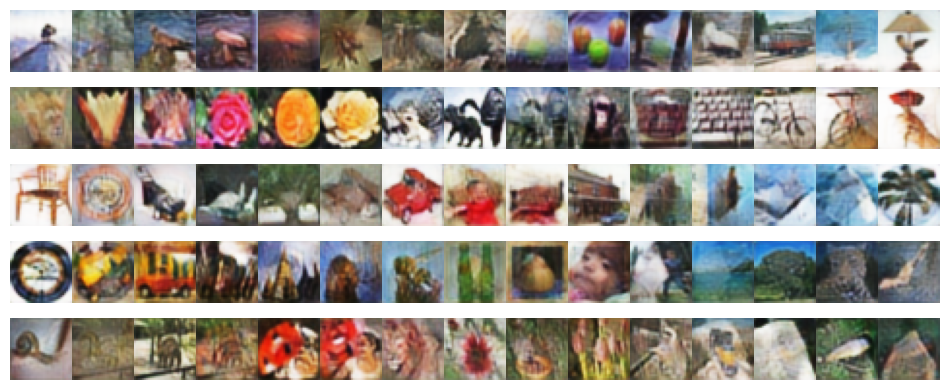

In [18]:
num_rows, num_cols = 5, 15
fig, axs = plt.subplots(num_rows, num_cols)
fig.set_figwidth(12)
fig.set_figheight(5)
count = 0
for row in range(num_rows):
    for col in range(num_cols):
        axs[row, col].imshow(reconstructions[count])
        axs[row, col].axis("off")
        count += 1
plt.subplots_adjust(wspace = 0.0, hspace = 0.0)
plt.show()